# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []
max_num_categories = 5

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [0]:
!mkdir quick_draw_data
os.chdir("/content/quick_draw_data")

In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)
  os.system("mkdir train/" + aux)
  os.system("mkdir test/" + aux)

In [6]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/motorbike.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/canoe.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/bat.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/spreadsheet.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/river.ndjson


In [7]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if cat + ".ndjson" not in categories:
    print("falta " + cat)

7


In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 classnames,
                 output_shards=10,
                 offset=0):
  """Convert training data from ndjson files into tf.Example in tf.Record.
  Args:
   trainingdata_dir: path to the directory containin the training data.
     The training data is stored in that directory as ndjson files.
   observations_per_class: the number of items to load per class.
   output_file: path where to write the output.
   classnames: array with classnames - is auto created if not passed in.
   output_shards: the number of shards to write the output in.
   offset: the number of items to skip at the beginning of each file.
  Returns:
    classnames: the class names as strings. classnames[classes[i]] is the
      textual representation of the class of the i-th data point.
  """
  
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue   
   
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break
    
    reading_order = range(len(file_handles)) * observations_per_class
    random.shuffle(reading_order)
          
    for c in reading_order:
      line = file_handles[c].readline()
      ink = None
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")
    
      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      for linea in ink:
        for idx in range(len(linea[0])-1):
          #pdb.set_trace()
          rr, cc = drawLine(linea[1][idx], linea[0][idx], linea[1][idx+1], linea[0][idx+1])
          drawing[rr, cc] = 1
      
      plt.imshow(drawing)
      plt.show()
      pdb.set_trace()
    
      if class_name not in classnames:
        classnames.append(class_name)

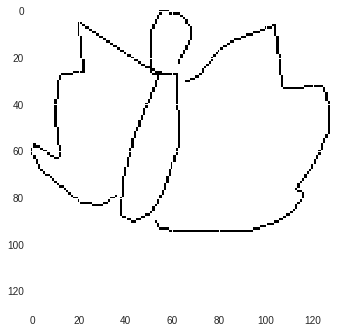

> <ipython-input-49-712b94ab790e>(82)convert_data()
-> if class_name not in classnames:
(Pdb) c


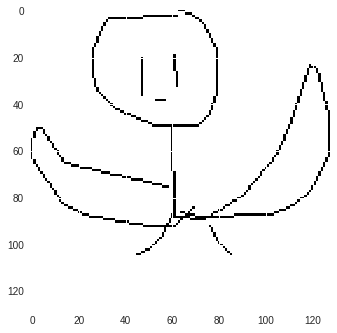

> <ipython-input-49-712b94ab790e>(80)convert_data()
-> pdb.set_trace()
(Pdb) c


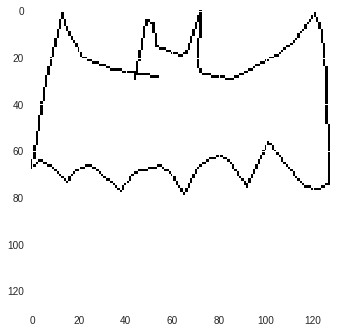

> <ipython-input-49-712b94ab790e>(82)convert_data()
-> if class_name not in classnames:
(Pdb) q


BdbQuit: ignored

In [50]:
train_samples_per_cat = 5

convert_data(".",
             train_samples_per_cat,
             "train/",
             [])    

In [13]:
!ls

fish.ndjson	pear.ndjson  test	   train
octagon.ndjson	peas.ndjson  tooth.ndjson


In [2]:
!ls wheel

ls: cannot access 'wheel': No such file or directory


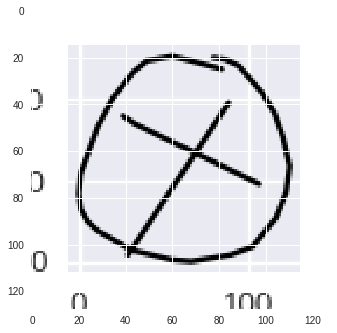

In [84]:
figure = plt.imread("wheel/90.png")
plt.imshow(figure)